# scTransform

As a single-cell RNA sequencing transform method, scTransform uses regularized negative binomial regression to normalize the express matrix of UMI [Hafemeister19].

## Differences with Normalizations 

Before exploring scTransform, let's review what classic normalization and log, does.

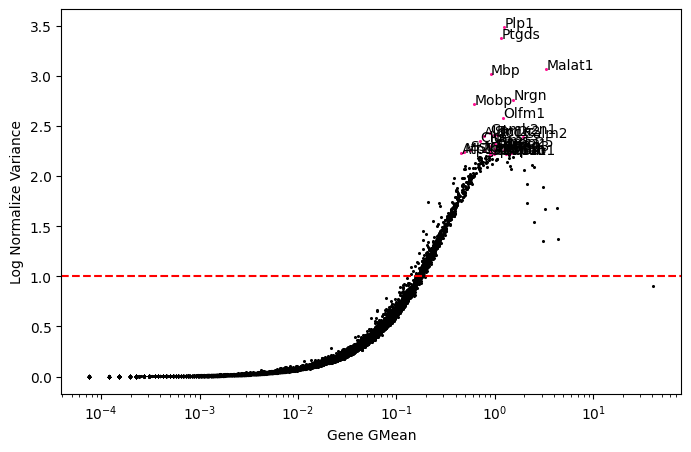

In [5]:
import sys
import stereo as st
import pandas as pd
import numpy as np

# read data
data1 = st.io.read_gef('D:/Data/Stereopy/SS200000135TL_D1.tissue.gef')
data1.sparse2array()

gmean = np.exp(np.log(data1.exp_matrix.T + 1).mean(1)) - 1

# preprocessing
data1.tl.raw_checkpoint()
data1.tl.normalize_total(target_sum=1e4)
data1.tl.log1p()

log_normalize_result = pd.DataFrame([gmean, data1.exp_matrix.T.var(1)], index=['gmean', 'log_normalize_variance'], columns=data1.gene_names).T

from stereo.algorithm.sctransform.plotting import plot_log_normalize_var

fig1=plot_log_normalize_var(log_normalize_result)

After log-normalization, it is apparently observed that lowly expressed genes contribute just a little variance in this sample.

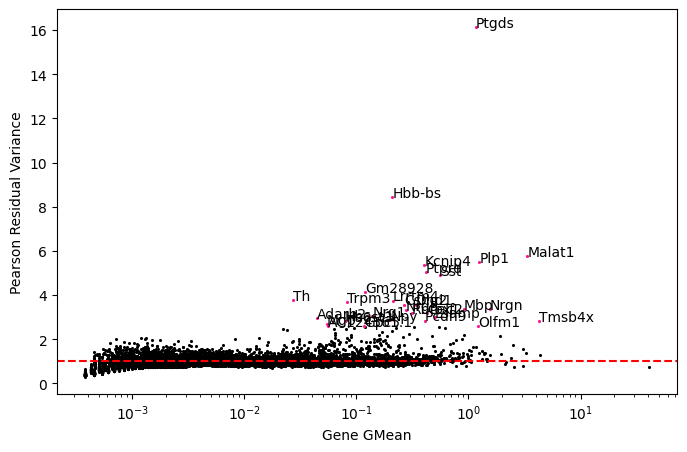

In [6]:
data2 = st.io.read_gef('D:/Data/Stereopy/SS200000135TL_D1.tissue.gef')
data2.tl.sctransform(res_key='sctransform', inplace=True, filter_hvgs=True)

from stereo.algorithm.sctransform.plotting import plot_residual_var

fig2=plot_residual_var(data2.tl.result['sctransform'])

Whereas, after scTransform, gene express matrix is transformed from raw counts to Pearson residual. Different with log-normalization method, scTransform balances variance distribution of all genes, which means that not only highly expressed genes make sense, so do the lowly expressed genes.

Let us take some genes from a real dataset after normalization by scTransform, compare their variance distribution to that normalized with log.

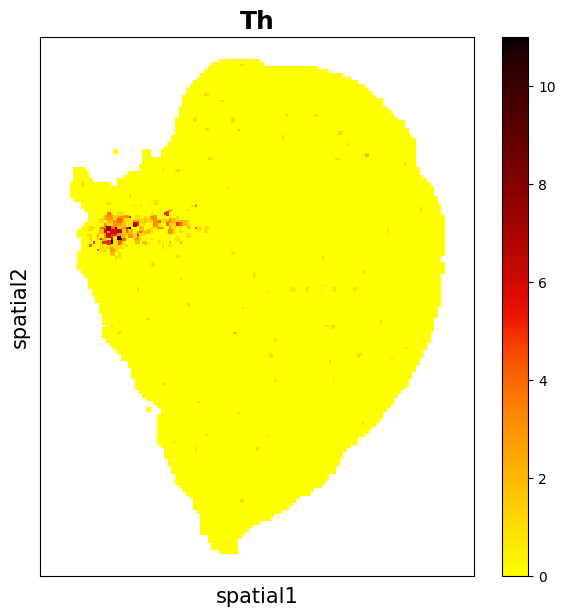

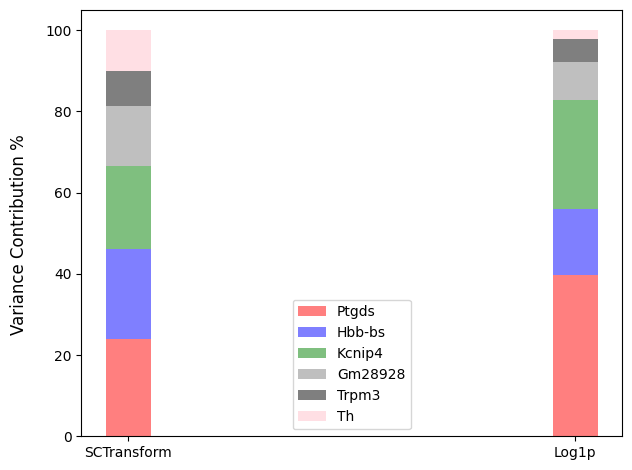

In [8]:
data3 = st.io.read_gef('D:/Data/Stereopy/SS200000135TL_D1.tissue.gef')
data3.tl.cal_qc()
data3.plt.spatial_scatter_by_gene(gene_name='Th')

from stereo.algorithm.sctransform.plotting import plot_genes_var_contribution

fig3=plot_genes_var_contribution(data3, gene_names=['Ptgds','Hbb-bs', 'Kcnip4', 'Gm28928', 'Trpm3', 'Th'])

The expression of gene Th is low. In the norlization method of log1p, although variance contribution is reduced, the spots of gene Th are concentrated in a certain region. When using standardization methond of scTransform, the variance contribution can be improved.

More contribution from lowly expressed genes might help us focus on tiny differentiation between subtypes within cell clusters, which is barely found because of over shrinking of log sometimes.

## Clustering after Different Normalizations

### Normalization via scTransform

For further exploration, let's try clustering method on these result. Note that scTransform defaults to sampling with 5000 cells and 2000 genes for estimating parameters. If want to fit with more cells, adjust the `n_cells` and `n_genes` parameters.

In [10]:
import sys
import stereo as st
import time

# read data
data_sct = st.io.read_gef('D:/Data/Stereopy/SS200000135TL_D1.tissue.gef')

# preprocessing
data_sct.tl.cal_qc()
data_sct.tl.sctransform(res_key='sctransform', inplace=True, filter_hvgs=True, n_cells=5000, n_genes=2000)

# embedding
data_sct.tl.pca(use_highly_genes=False, hvg_res_key='highly_variable_genes', n_pcs=20, res_key='pca', svd_solver='arpack')
data_sct.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors', n_jobs=8)
data_sct.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap', init_pos='spectral', spread=2.0)

# clustering
data_sct.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Get the list of Top 10 feature genes.

In [17]:
sct_high_genes = data_sct.tl.result['sctransform'][1]['top_features']
sct_high_genes.tolist()[:10]

['Ptgds',
 'Hbb-bs',
 'Malat1',
 'Plp1',
 'Kcnip4',
 'Ptprd',
 'Sst',
 'Gm28928',
 'Th',
 'Trpm3']

### Normalization via Others

In [13]:
# read data
data = st.io.read_gef('D:/Data/Stereopy/SS200000135TL_D1.tissue.gef')

# preprocessing
data.tl.filter_genes(gene_list=sct_high_genes.tolist())
data.tl.cal_qc()
data.tl.normalize_total()
data.tl.log1p()
data.tl.scale()

# embedding
data.tl.pca(use_highly_genes=False, hvg_res_key='highly_variable_genes', n_pcs=20, res_key='pca', svd_solver='arpack')
data.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors', n_jobs=8)
data.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap', init_pos='spectral', spread=2.0)

# clustering
data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


### Embedding Comparison

<AxesSubplot:title={'center':'leiden'}, xlabel='umap1', ylabel='umap2'>

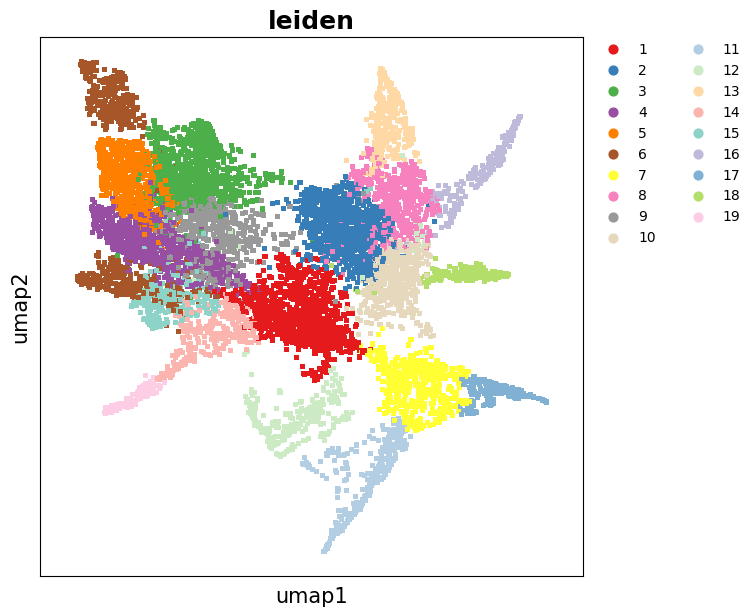

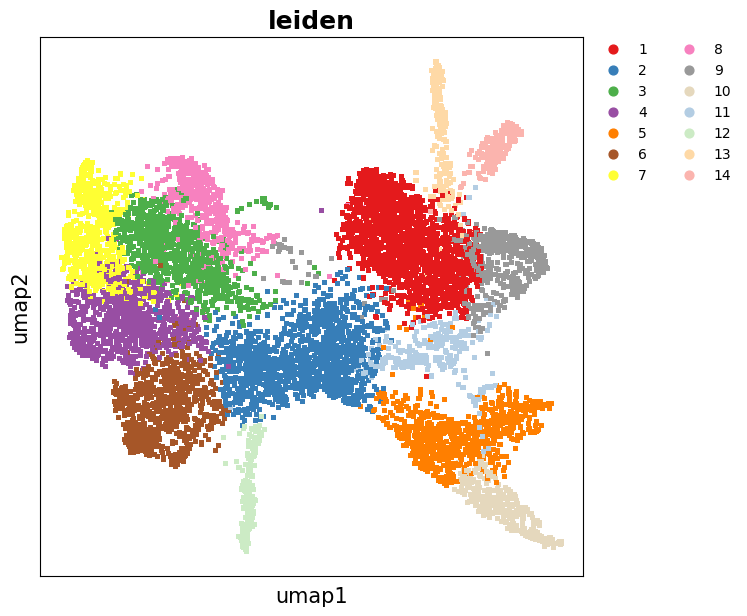

In [16]:
data_sct.plt.umap(res_key='umap', cluster_key='leiden')
data.plt.umap(res_key='umap', cluster_key='leiden')

### Gene Distribution

Observe the distribution of the gene Ptgds.

<AxesSubplot:xlabel='umap1', ylabel='umap2'>

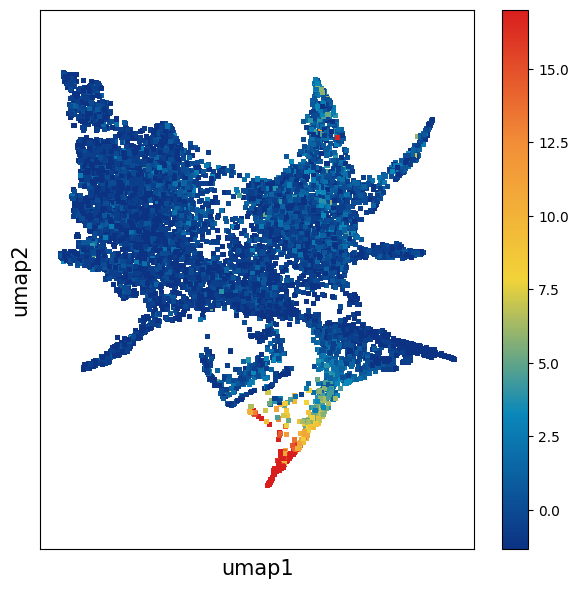

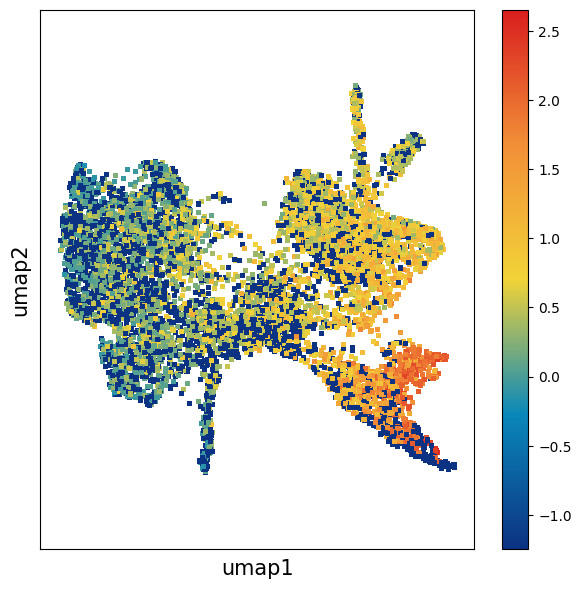

In [18]:
data_sct.plt.umap(res_key='umap', gene_names=['Ptgds'])
data.plt.umap(res_key='umap', gene_names=['Ptgds'])

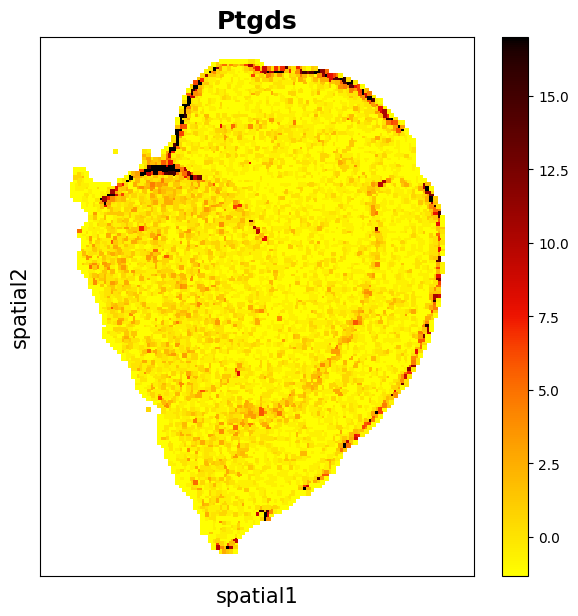

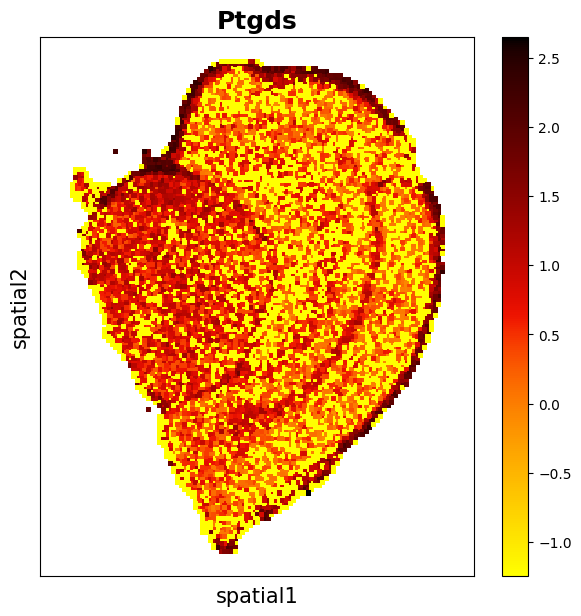

In [19]:
data_sct.plt.spatial_scatter_by_gene(gene_name='Ptgds')
data.plt.spatial_scatter_by_gene(gene_name='Ptgds')